# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/GEOP/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


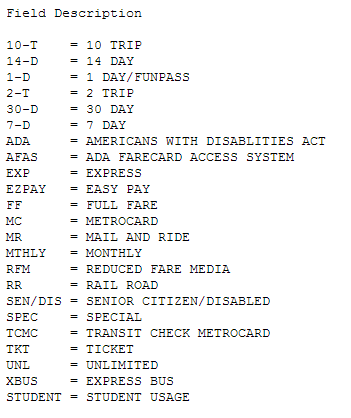

In [27]:
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# Read in Data as Instructed Above

In [11]:
!curl -LJO https://raw.github.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.2M  100 10.2M    0     0  21.6M      0 --:--:-- --:--:-- --:--:-- 21.6M


In [2]:
mtaRides = np.load("MTA_Fare.npy")

In [3]:
print ("MTA array shape:", mtaRides.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mtaRides,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


# Create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [5]:
mtaRides.shape #(#of stations, # of subway card types, # of weeks)

(600, 23, 194)

In [6]:
#Basically, for each station in the subway, for each subway card types, we have number of card swipes.
# Station 1: Subway Card Type 1: [1, 2, 3, ....., 194]
# Station 1: Subway Card Type 2: [1, 2, 3, ....., 194]
# Station 1: Subway Card Type 3: [1, 2, 3, ....., 194]
# ...
# Station 1: Subway Card Type 23: [1, 2, 3, ....., 194]

# Station 2: Subway Card Type 1: [1, 2, 3, ....., 194]
# Station 2: Subway Card Type 2: [1, 2, 3, ....., 194]
# Station 2: Subway Card Type 3: [1, 2, 3, ....., 194]
# ...
# Station 2: Subway Card Type 23: [1, 2, 3, ....., 194]

# ...
# Station 600: Subway Card Type 23: [1, 2, 3, ....., 194]

### You need to create a date range to plot properly. 
### After that I create a date range (for example with pd.date_range())
### in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
### all time series, each station each ride type, look like this (pretty ugly)

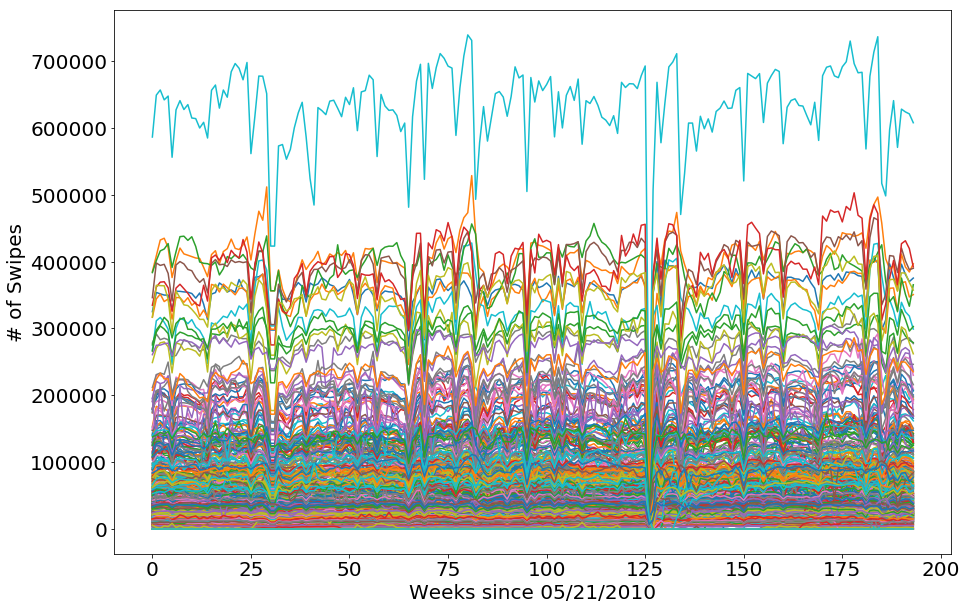

In [6]:
# mtaRides[0,:,0]
# Basically, we want to plot the number of weeks vs total rides per subway.
# For Subway 1, one line plot that shows how the total rides is fluctuating as the weeks go by.

# To get the total rides, we need to sum up the counts of the different 23 sub rides.
no_of_subways = mtaRides.shape[0]
no_of_ride_types = mtaRides.shape[1]
no_of_weeks = mtaRides.shape[2]

pl.figure(figsize=(15,10))
for i in range(0, no_of_subways):
    # ith subway, jth week, summing all 23 ride types
    all_rides = [sum(mtaRides[i,:, j]) for j in range(0, no_of_weeks)] 
    pl.plot(all_rides)
    
pl.xlabel("Weeks since 05/21/2010", fontsize=20)
tmp = pl.ylabel("# of Swipes", fontsize=20)

In [7]:
#create time range based on metadata
rng = pd.date_range(start='05/21/2010', periods=no_of_weeks, freq='W')
print("Nominal Date Range Given the Metadata\n", rng)

Nominal Date Range Given the Metadata
 DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')


Text(0,0.5,'# of swipes (log10)')

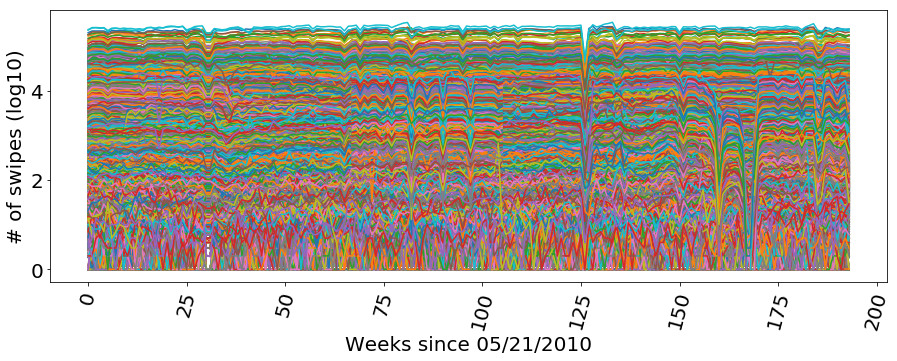

In [8]:
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
mtaRides = mtaRides.astype(float)
mtaRides[mtaRides == -1] = float('NaN')
logrides = np.log10(mtaRides)
for j in range(no_of_ride_types):
    print (j,"/23")
    clear_output(wait=True)
    for i in range(no_of_subways):
        pl.plot(logrides[i,j])
pl.xticks(rotation = 75, fontsize=20)
pl.xlabel("Weeks since 05/21/2010", fontsize=20)
pl.ylabel("# of swipes (log10)", fontsize=20)   

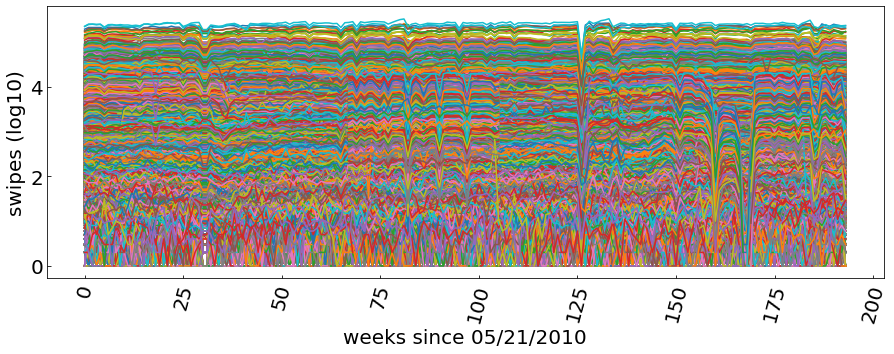

In [12]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)


#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: Event Detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 


In [9]:
# summing across all the 600 subways -> 1 aggregated subway with 23 subRides across 196 weeks
mta_allsum = np.nansum(mtaRides, axis=0)
print ("MTA array collapsing station axis:", mta_allsum.shape)
# summing across all the 23 subRides -> 1 aggregated subway with 1 aggregated subRides across 196 weeks
mta_allsum = np.nansum(mta_allsum, axis=0)
print ("MTA array collapsing ride type and station axes:", mta_allsum.shape)

MTA array collapsing station axis: (23, 194)
MTA array collapsing ride type and station axes: (194,)


In [10]:
#need to convert to use datetime index w fill_between (pandas 0.21) >0.21)
d = [pd.Timestamp(x).to_pydatetime() for x in rng]

In [11]:
np.std(mta_allsum)

2983960.421700886

In [12]:
np.nanmean(mta_allsum) - 3 * np.std(mta_allsum)

20829468.606031362

3 Sigma Threshold 20829468.6
Outlier Index (array([126]),)
Outlier Date DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq=None)


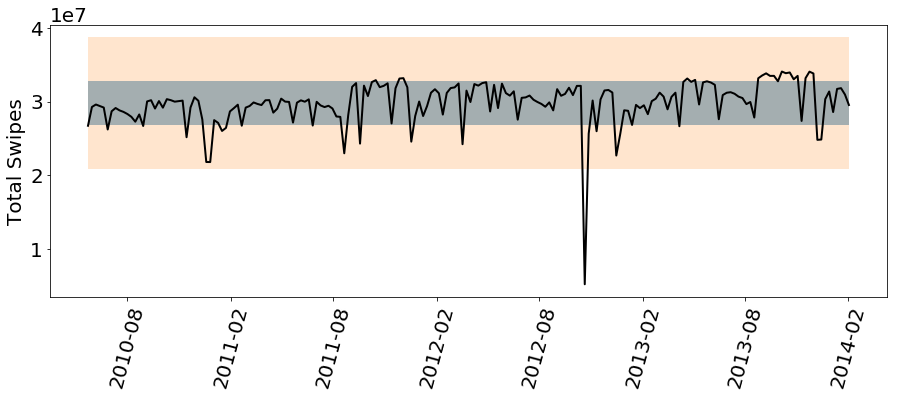

In [13]:
#plot all swipes
pl.figure(figsize=(15,5))
onesig = np.std(mta_allsum)
tsthresh = np.nanmean(mta_allsum)  - 3 * onesig # since it mentions drop
print ("3 Sigma Threshold %.1f"%tsthresh)
print ("Outlier Index", np.where(mta_allsum < tsthresh)) # finding all the indices that go below the threshold
print ("Outlier Date", rng[np.where(mta_allsum < tsthresh)]) # finding the date associated with the index
pl.fill_between(d, np.nanmean(mta_allsum) - onesig,
                np.nanmean(mta_allsum) + onesig, alpha=0.5)
pl.fill_between(d, np.nanmean(mta_allsum) - 3 * onesig,
                 np.nanmean(mta_allsum) + 3 * onesig, alpha = 0.2)
#pl.fill_between(weighted +threesigma(weighted , 10), weighted -threesigma(weighted 
pl.plot(d, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("Total Swipes", fontsize=20)  ;

**Figure 3a: The sum of all MTA swipe time series, and the three- and one-sigma thresholds indicated as shaded regions**

**The outlier is near the date of sandy, but I am off by a week. I will reset the range accordingly**

First Day  2010-05-30
Outlier Date 2012-10-28


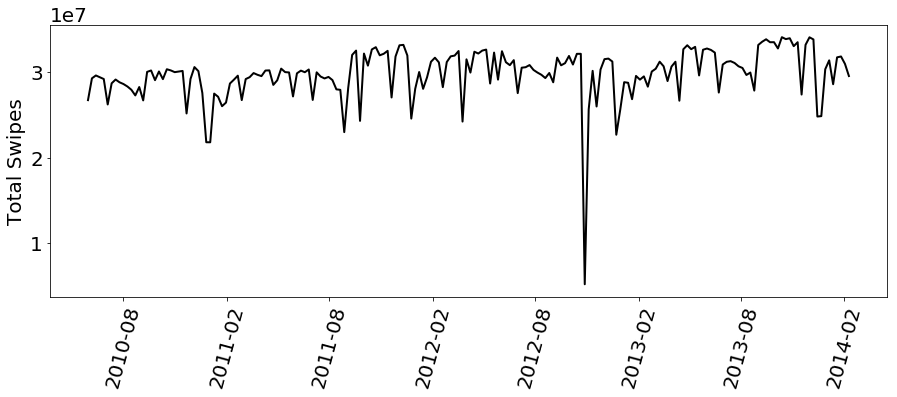

In [14]:
rng = pd.date_range('05/29/2010', periods=no_of_weeks, freq='W')
#need to convert to use datetime index w fill_between (pandas 0.21) >0.21)
d = [pd.Timestamp(x).to_pydatetime() for x in rng]#plot all swipes
print ("First Day ", d[0].date())
pl.figure(figsize=(15,5))
pl.plot(d, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("Total Swipes", fontsize=20)  
print ("Outlier Date", rng[np.where(mta_allsum < tsthresh)][0].date())

**Figure 3b: Sum of all MTA swipe time series, with corrected timeline: the time range covers 194 weeks starting on 2010-05-30 as confirmed by the most significant drop in ridership aligning with Hurricane Sandy, in the week of 2012-10-28, when MTS shut down for several days.**

A more representative way to show this is to plot the weighted average of all rides, weighted by ticket popularity.

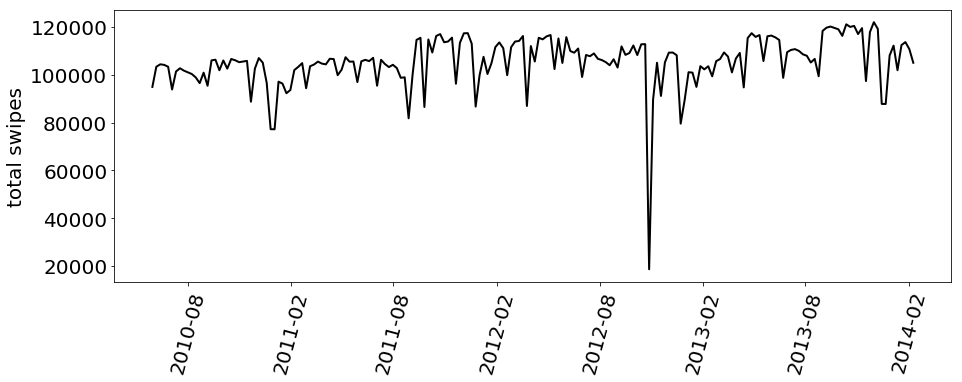

In [15]:
weightedrides = np.zeros((no_of_subways, no_of_weeks))

for i in range(no_of_subways):
    allrides = np.array([np.nansum(mtaRides[i,:,j].flatten()) for j in range(no_of_weeks)])
    #print (allrides/nanmean(allrides)).shape, weightedrides.shape
    weightedrides[i] = allrides / np.sqrt(nanmean(allrides))
    #pl.plot(rng, np.log10(weightedrides[i]))
    #pl.xticks(rotation = 75)

    
#plot weighted by station, per ride
pl.figure(figsize=(15,5))
pl.plot(d, np.nansum(weightedrides, axis=0), 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
rides = pd.DataFrame({'t':rng, 'ridecounts':np.nansum(weightedrides, axis=0)})

**Figure 3: time series for all rides weighted by mean number of rides per ticket type in semi-log space**

 # 2: Finding Trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


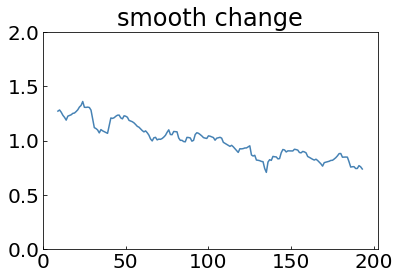

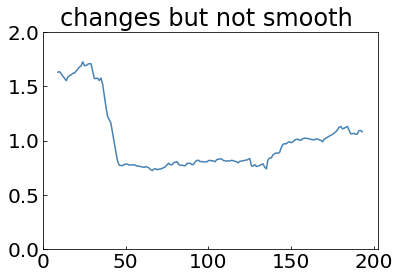

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

stdev 546777.62, fractional increase over time 1.05: 
stdev 64593.90, fractional increase over time 1.33: 
stdev 5767.41, fractional increase over time 1.17: 
stdev 8828.00, fractional increase over time 0.97: 
stdev 3624.09, fractional increase over time 1.07: 
stdev 631955.02, fractional increase over time 1.46: 
stdev 473487.37, fractional increase over time 0.92: 
stdev 3794.93, fractional increase over time 0.00: 
stdev 101444.89, fractional increase over time 0.00: 
stdev 206370.78, fractional increase over time 0.00: 
stdev 18800.95, fractional increase over time 0.87: 
stdev 25371.32, fractional increase over time 1.23: 
stdev 61154.07, fractional increase over time 26332.33: 
stdev 17282.83, fractional increase over time 0.60: 
stdev 153165.98, fractional increase over time 0.65: 
stdev 33309.14, fractional increase over time 2.64: 
stdev 18139.76, fractional increase over time 2.94: 
stdev 10350.80, fractional increase over time 76.86: 
stdev 30841.45, fractional increase ove

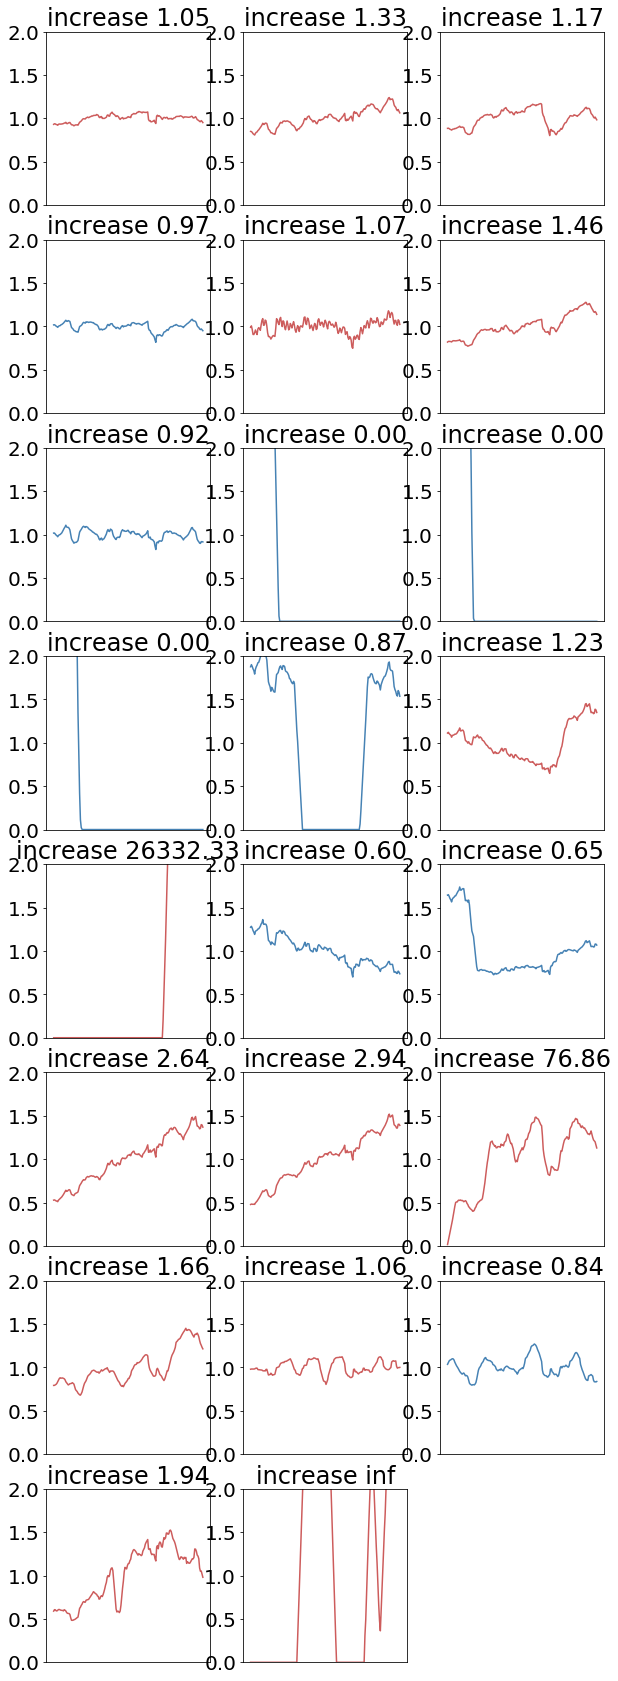

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Filtering out NaN values (in this case, it's -1)
mtaRides_NaNs_removed = np.empty_like(mtaRides)
for i,m in enumerate(mtaRides):
    for j,t in enumerate(m):
        if not -1 in t:
            mtaRides_NaNs_removed[i][j] = t
        
        
increase = np.zeros((no_of_ride_types,2)) # initializing empty array of size (23, 2)
fig = pl.figure(figsize=(10,30))

for i in range(no_of_ride_types): # iterating over each ride type
    mta_allsum = mtaRides_NaNs_removed[:,i,:] # selecting each ride type (size = (600, 194))
    ax = fig.add_subplot(8,3,i+1)
    #rolling mean of rides by type
    thisride = pd.rolling_mean(np.nansum(mta_allsum, axis=0), 10) # computing the rolling mean with
    increase[i] = np.array([np.nanstd(thisride), 
                   np.nanmean(thisride[-10:]) / np.nanmean(thisride[:10])])
    print ("stdev {0:.2f}, fractional increase over time {1:.2f}: ".format(increase[i][0], 
                                                                            increase[i][1]))
    if increase[i][1] > 1:
        pl.plot(thisride / np.nanmean(thisride), color="IndianRed")
    else: 
        pl.plot(thisride / np.nanmean(thisride), color="SteelBlue")
    pl.ylim(0,2)
    pl.xticks([])
    pl.title("increase %.2f"%(increase[i][1]))

In [18]:
increase

array([[  5.46777617e+05,   1.05077140e+00],
       [  6.45939014e+04,   1.32792127e+00],
       [  5.76741249e+03,   1.17065266e+00],
       [  8.82800386e+03,   9.72991095e-01],
       [  3.62408853e+03,   1.06977117e+00],
       [  6.31955018e+05,   1.45776367e+00],
       [  4.73487373e+05,   9.20869998e-01],
       [  3.79492677e+03,   2.03072496e-04],
       [  1.01444892e+05,   1.06259639e-05],
       [  2.06370776e+05,   1.98591933e-06],
       [  1.88009465e+04,   8.65808425e-01],
       [  2.53713236e+04,   1.23101213e+00],
       [  6.11540734e+04,   2.63323276e+04],
       [  1.72828339e+04,   6.01948194e-01],
       [  1.53165984e+05,   6.49575518e-01],
       [  3.33091354e+04,   2.63733167e+00],
       [  1.81397619e+04,   2.93889441e+00],
       [  1.03507976e+04,   7.68648458e+01],
       [  3.08414543e+04,   1.66346651e+00],
       [  1.57054061e+03,   1.05864579e+00],
       [  6.81416737e+02,   8.43546172e-01],
       [  2.52041044e+02,   1.93712726e+00],
       [  

In [19]:
mtaRides_NaNs_removed.shape[1]

23

# 3. Build  models that classifies the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

### Ilyas's Solution

I will convert the 3-dimensional numpy array to a DataFrame. I do this because it will make it more intuitive and make my machine learning modeling a lot easier.

In [16]:
# Creating a DataFrame where rows = (600*23) and columns = (194)
m,n,r = mtaRides.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),mtaRides.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)

out_df

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,0.0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,...,43608.0,44774.0,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0
1,0.0,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,...,1425.0,1085.0,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0
2,0.0,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,...,217.0,189.0,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0
3,0.0,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,...,576.0,460.0,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0
4,0.0,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,...,290.0,109.0,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0
5,0.0,17654.0,20249.0,20325.0,20852.0,20079.0,21256.0,20775.0,21002.0,21543.0,...,17107.0,20969.0,26134.0,14524.0,13650.0,11904.0,12894.0,14153.0,13389.0,15042.0
6,0.0,32369.0,42599.0,41423.0,42667.0,42415.0,38055.0,42020.0,41372.0,41836.0,...,17915.0,11791.0,11797.0,18286.0,19460.0,16558.0,19710.0,19722.0,18898.0,17518.0
7,0.0,59.0,60.0,67.0,61.0,51.0,50.0,58.0,46.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,6733.0,5487.0,6237.0,7272.0,7752.0,9348.0,7783.0,8174.0,8749.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1835.0,2320.0,2521.0,2759.0,2673.0,3561.0,3823.0,4313.0,4273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the above DataFrame, column 0 indicates the subway station number. The rest of the columns, 1 to 194, indicate week numbers.

### Engineering Feature 1 - mean(ts) / mean(station) and Feature 2 - std(ts) / std(station)

Let us focus on the numerator first. To calculate mean(ts), I just to calculate the mean of each of my rows. Same for std(ts).

In [17]:
# Mean and Std. Deviation of each time series (i.e., 194) for each station
out_df['mean_ts'] = out_df.iloc[:, 1:].mean(axis=1)
out_df['std_ts'] = out_df.iloc[:, 1:].std(axis=1)

out_df.head(25)

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,mean_ts,std_ts
0,0.0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,...,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0,58586.885417,17761.092039
1,0.0,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,...,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0,1828.182292,510.965674
2,0.0,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,...,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0,237.322917,66.531712
3,0.0,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,...,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0,737.656250,187.212631
4,0.0,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,...,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0,293.140625,140.824159
5,0.0,17654.0,20249.0,20325.0,20852.0,20079.0,21256.0,20775.0,21002.0,21543.0,...,26134.0,14524.0,13650.0,11904.0,12894.0,14153.0,13389.0,15042.0,20033.307292,5934.298672
6,0.0,32369.0,42599.0,41423.0,42667.0,42415.0,38055.0,42020.0,41372.0,41836.0,...,11797.0,18286.0,19460.0,16558.0,19710.0,19722.0,18898.0,17518.0,30557.296875,10025.548001
7,0.0,59.0,60.0,67.0,61.0,51.0,50.0,58.0,46.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.572917,18.735130
8,0.0,6733.0,5487.0,6237.0,7272.0,7752.0,9348.0,7783.0,8174.0,8749.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,977.171875,2314.857230
9,0.0,1835.0,2320.0,2521.0,2759.0,2673.0,3561.0,3823.0,4313.0,4273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,431.281250,991.813120


Before we proceed further, let us generate our labels first. Our labels are the card type (or the rider Type). These card types are in increasing order of 0, 1, 2, ..., 22. This repeats 600 times as there are 600 subway stations.

In [18]:
labels = [[i for i in range(0, 23)] for j in range(0, 600)] # Generating a list of labels
flat_labels = [item for sublist in labels for item in sublist] # Flattening them

len(flat_labels)

13800

Now, we focus on the denominator, i.e., calculating mean(station) and std(station). To do this, I take the mean/std of each mean/std(ts) I calculated earlier for each subway.

In [19]:
# Mean and Std. Deviation of each station
mean_station = [out_df.loc[(out_df[0] == i)]['mean_ts'].mean() for i in range(0, 600)]
std_station = [out_df.loc[(out_df[0] == i)]['mean_ts'].mean() for i in range(0, 600)]

for ind, val in enumerate(mean_station):
    out_df.loc[(out_df[0] == ind), 'mean_station'] = val
    out_df.loc[(out_df[0] == ind), 'std_station'] = val

out_df['label'] = flat_labels

In [20]:
#Feature Engineering variables 1 and 2
out_df['feat_1_normedtsmean'] = out_df['mean_ts'] / out_df['mean_station'] 
out_df['feat_2_normedtsstd'] = out_df['std_ts'] / out_df['std_station'] 

out_df.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,mean_ts,std_ts,mean_station,std_station,label,feat_1_normedtsmean,feat_2_normedtsstd
0,0.0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,...,36527.0,33929.0,36824.0,58586.885417,17761.092039,5265.900634,5265.900634,0,11.125710,3.372850
1,0.0,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,...,1264.0,1172.0,1238.0,1828.182292,510.965674,5265.900634,5265.900634,1,0.347174,0.097033
2,0.0,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,...,186.0,167.0,167.0,237.322917,66.531712,5265.900634,5265.900634,2,0.045068,0.012634
3,0.0,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,...,545.0,516.0,489.0,737.656250,187.212631,5265.900634,5265.900634,3,0.140082,0.035552
4,0.0,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,...,281.0,309.0,245.0,293.140625,140.824159,5265.900634,5265.900634,4,0.055668,0.026743


We successfully created features 1 and feature 2. Before we proceed further, it might be a good idea to filter out the NaN values.

In [21]:
out_df_nans_removed = out_df[~out_df.isnull().any(axis=1)].copy() #not considering any ts which has NaN values

len(out_df_nans_removed)

9174

In [22]:
out_df_nans_removed.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,mean_ts,std_ts,mean_station,std_station,label,feat_1_normedtsmean,feat_2_normedtsstd
46,2.0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,...,3746.0,3406.0,3217.0,3548.917526,391.400424,322.227919,322.227919,0,11.013687,1.214669
47,2.0,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,...,212.0,209.0,211.0,144.587629,43.600755,322.227919,322.227919,1,0.448712,0.135310
48,2.0,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,...,26.0,20.0,22.0,17.938144,8.137117,322.227919,322.227919,2,0.055669,0.025253
49,2.0,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,...,28.0,24.0,22.0,30.257732,9.809819,322.227919,322.227919,3,0.093902,0.030444
50,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,5.0,6.0,0.0,2.896907,4.235307,322.227919,322.227919,4,0.008990,0.013144


### Engineering Feature 3 - intercept and Feature 4 - slope of the OLS line fit to a standardized ts

In [23]:
intercept = []
slope = []

for i in out_df_nans_removed.index:
    standardized_ts = (out_df_nans_removed.loc[i, [i for i in range(1, 195)]] - out_df_nans_removed.loc[i, 'mean_ts'])/out_df_nans_removed.loc[i, 'std_ts']
    ols_res = sm.OLS(standardized_ts, sm.add_constant(np.arange(1, 195))).fit()
#     ols_res = sm.OLS(out_df_nans_removed.iloc[i][:-7], sm.add_constant(np.arange(1, 195))).fit()
    intercept.append(ols_res.params[0])
    slope.append(ols_res.params[1])
    
len(intercept)

9174

In [24]:
standardized_ts = [(out_df_nans_removed.loc[i, [i for i in range(1, 195)]] - out_df_nans_removed.loc[i, 'mean_ts'])/out_df_nans_removed.loc[i, 'std_ts'] for i in out_df_nans_removed.index]

Text(0,0.5,'standardized number of rides')

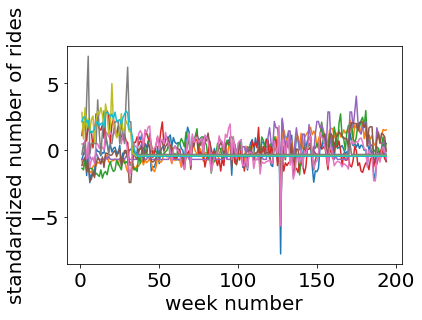

In [25]:
for i in range(10):
    pl.plot(standardized_ts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [26]:
#Feature Engineering variables 3 and 4

out_df_nans_removed['feat_3_slope'] = slope
out_df_nans_removed['feat_4_intercept'] = intercept

out_df_nans_removed.head(20)

,0,1,2,3,4,5,6,7,8,9,...,194,mean_ts,std_ts,mean_station,std_station,label,feat_1_normedtsmean,feat_2_normedtsstd,feat_3_slope,feat_4_intercept
46,2.0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,...,3217.0,3548.917526,391.400424,322.227919,322.227919,0,11.013687,1.214669,0.000098,-0.009514
47,2.0,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,...,211.0,144.587629,43.600755,322.227919,322.227919,1,0.448712,0.135310,0.015075,-1.469804
48,2.0,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,...,22.0,17.938144,8.137117,322.227919,322.227919,2,0.055669,0.025253,0.011078,-1.080146
49,2.0,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,...,22.0,30.257732,9.809819,322.227919,322.227919,3,0.093902,0.030444,-0.011059,1.078238
50,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,2.896907,4.235307,322.227919,322.227919,4,0.008990,0.013144,0.010605,-1.033987
51,2.0,1404.0,1514.0,1577.0,1268.0,1470.0,1063.0,1108.0,1265.0,1143.0,...,1708.0,1726.664948,286.208932,322.227919,322.227919,5,5.358521,0.888219,0.009030,-0.880399
52,2.0,1344.0,1344.0,1397.0,1145.0,1366.0,1024.0,1124.0,1162.0,1074.0,...,1150.0,1258.737113,182.351360,322.227919,322.227919,6,3.906356,0.565908,-0.005927,0.577884
53,2.0,0.0,1.0,0.0,5.0,9.0,0.0,1.0,1.0,1.0,...,0.0,0.386598,1.226858,322.227919,322.227919,7,0.001200,0.003807,-0.007740,0.754636
54,2.0,36.0,14.0,40.0,23.0,31.0,21.0,30.0,33.0,11.0,...,0.0,4.628866,11.116366,322.227919,322.227919,8,0.014365,0.034498,-0.010825,1.055473
55,2.0,174.0,196.0,196.0,170.0,179.0,128.0,116.0,124.0,139.0,...,0.0,30.061856,67.146833,322.227919,322.227919,9,0.093294,0.208383,-0.011436,1.115015


In [277]:
# temp = (out_df_nans_removed.iloc[0][:-7] - out_df_nans_removed.loc[46, 'mean_ts'])/out_df_nans_removed.loc[46, 'std_ts']

# sm.OLS(temp, sm.add_constant(np.arange(1, 195))).fit().params

const   -0.009514
x1       0.000098
dtype: float64

Finally, we engineered all the required features. One thing to notice is that our newly engineed features themselves have NaN values. So we filter them out as well.

In [27]:
# Removing rows which have NaN slope and intercept
out_df_nans_removed_2 = out_df_nans_removed[~out_df_nans_removed.isnull().any(axis=1)].copy()
# out_df_nans_removed_2 = out_df_nans_removed.loc[(out_df_nans_removed.feat_3_slope != 0) | (out_df_nans_removed.feat_4_intercept != 0)].copy()

len(out_df_nans_removed_2)

7660

### Model 1: Random Forest Model based on Engineered Features (# Features = 4)

In [28]:
model_1_df = out_df_nans_removed_2.loc[:, ['feat_1_normedtsmean', 'feat_2_normedtsstd', 'feat_3_slope', 'feat_4_intercept',
                                        'label']].copy()

model_1_df.head()

,feat_1_normedtsmean,feat_2_normedtsstd,feat_3_slope,feat_4_intercept,label
46,11.013687,1.214669,0.000098,-0.009514,0
47,0.448712,0.135310,0.015075,-1.469804,1
48,0.055669,0.025253,0.011078,-1.080146,2
49,0.093902,0.030444,-0.011059,1.078238,3
50,0.008990,0.013144,0.010605,-1.033987,4


In [29]:
model_1_X = model_1_df.drop('label', axis=1).copy()
model_1_y = model_1_df['label']

X_train, X_test, y_train, y_test = train_test_split(model_1_X, model_1_y, test_size=0.33, random_state=123)

In [30]:
# clf = rfc(n_estimators=100, max_depth=80, min_samples_split=12, min_samples_leaf=5, max_features=3, bootstrap=True)
clf = rfc(random_state=43) # Random Forest Classifier
clf.fit(X_train, y_train) # Fitting to the training data

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=43, verbose=0, warm_start=False)

In [31]:
y_pred = clf.predict(X_test) # Predicting on the Test Data

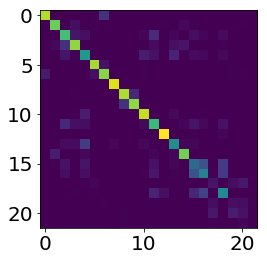

In [32]:
imshow(confusion_matrix(y_test, y_pred)) # Generating the Confusion Matrix

Let us look at how our Random Classifier Performed!

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.93      0.86      0.89       145
        14d       0.87      0.89      0.88       121
         1d       0.62      0.68      0.65       145
         2t       0.81      0.74      0.77       158
        30d       0.54      0.59      0.57       128
         7d       0.92      0.93      0.92       130
        ada       0.80      0.86      0.83       134
       afas       0.99      0.99      0.99       133
        exp       0.84      0.88      0.86       140
         ez       0.87      0.85      0.86       137
         ff       0.85      0.88      0.86       145
         mc       0.61      0.66      0.63       145
         mr       0.95      0.97      0.96       145
      month       0.69      0.62      0.65       111
        rfm       0.87      0.86      0.87       128
         rr       0.40      0.36      0.38       134
        sen       0.46      0.43      0.44       143
       spec       0.33      0.33      0.33   

In [34]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, col):
    
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")

    # X_train_2.shape[1]
    for f in range(4):
        print("%d. feature %s (%f)" % (f + 1, col[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(4), importances[indices][:4],
           color="r", yerr=std[indices][:4], align="center")
    plt.xticks(range(4), indices)
    plt.xlim([-1, 4])
    plt.show()

Feature ranking:
1. feature feat_1_normedtsmean (0.356745)
2. feature feat_2_normedtsstd (0.269173)
3. feature feat_3_slope (0.205035)
4. feature feat_4_intercept (0.169048)


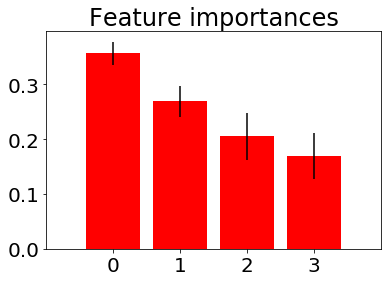

In [35]:
plot_feature_importance(clf, X_train.columns)

### Model 2: Random Forest Model based on Time Series Features (# Features = 194)

In [36]:
model_2_X = out_df_nans_removed_2.loc[:, [i for i in range(1, 195)]].copy()
model_2_y = out_df_nans_removed_2['label']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(model_2_X, model_2_y, test_size=0.33, random_state=42)

In [37]:
# clf2 = rfc(n_estimators=100, max_depth=80, min_samples_split=12, min_samples_leaf=5, max_features=3, bootstrap=True)
clf2 = rfc(random_state=123)
clf2.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [38]:
y_pred_2 = clf2.predict(X_test_2)

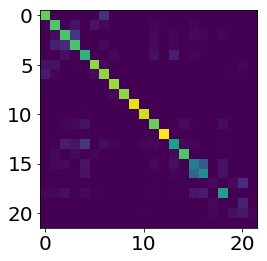

In [39]:
imshow(confusion_matrix(y_test_2, y_pred_2))

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test_2, y_pred_2, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.84      0.84      0.84       135
        14d       0.73      0.81      0.77       133
         1d       0.68      0.72      0.70       148
         2t       0.69      0.72      0.70       147
        30d       0.65      0.77      0.71       124
         7d       0.88      0.85      0.87       144
        ada       0.78      0.86      0.82       142
       afas       0.94      1.00      0.97       126
        exp       0.99      0.98      0.98       125
         ez       1.00      0.99      1.00       143
         ff       0.98      0.99      0.99       137
         mc       0.83      0.83      0.83       138
         mr       0.99      0.99      0.99       149
      month       0.75      0.58      0.65       146
        rfm       0.94      0.90      0.92       119
         rr       0.47      0.46      0.47       138
        sen       0.55      0.51      0.53       142
       spec       0.44      0.14      0.21   

Feature ranking:
1. feature 5 (0.020272)
2. feature 34 (0.016788)
3. feature 35 (0.015417)
4. feature 36 (0.015238)


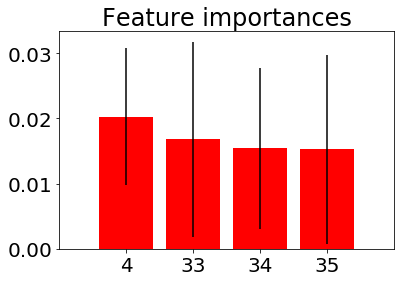

In [41]:
plot_feature_importance(clf2, X_train_2.columns)

### End of my Solution

### Pipelining Approach

In [38]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.cross import train_test_split
from sklearn.preprocessing import Imputer

In [39]:
m,n,r = mtaRides.shape #-1
out_arr = np.column_stack((np.repeat(np.arange(m),n),mtaRides.reshape(m*n,-1)))
df_pipeline = pd.DataFrame(out_arr)

# df_pipeline = df_pipeline.iloc[:, 1:].copy() # removing the column which indicates station number

labels = [[i for i in range(0, 23)] for j in range(0, 600)] # Generating a list of labels
flat_labels = [item for sublist in labels for item in sublist] # Flattening them

df_pipeline['label'] = flat_labels

df_pipeline.head()

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,label
0,0.0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,...,44774.0,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0,0
1,0.0,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,...,1085.0,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0,1
2,0.0,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,...,189.0,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0,2
3,0.0,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,...,460.0,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0,3
4,0.0,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,...,109.0,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0,4


In [ ]:
#0 - 22 - Subway
#23 - 45 - 
# 46 - 68 - 
# 69 - 91 - 
# 92 - 114 - 
#

In [40]:
class CreateFeat1And2(TransformerMixin):
    
#     def __init__(self, *_):
#         return self
        
    def transform(self, dataframe, *_):
        
        dataframe['mean_ts'] = dataframe.loc[:, [i for i in range(1, 195)]].mean(axis=1)
        dataframe['std_ts'] = dataframe.loc[:, [i for i in range(1, 195)]].std(axis=1)
        
        mean_station = [dataframe.loc[(dataframe[0] == i)]['mean_ts'].mean() for i in range(0, 600)]
        std_station = [dataframe.loc[(dataframe[0] == i)]['std_ts'].mean() for i in range(0, 600)]

        for ind, (val1, val2) in enumerate(zip(mean_station, std_station)):
            dataframe.loc[(dataframe[0] == ind), 'mean_station'] = val1
            dataframe.loc[(dataframe[0] == ind), 'std_station'] = val2
        
        dataframe['feat_1_normedtsmean'] = dataframe['mean_ts'] / dataframe['mean_station'] 
        dataframe['feat_2_normedtsstd'] = dataframe['std_ts'] / dataframe['std_station']
        
        
        return dataframe
    
    def fit(self, *_):
        return self

In [41]:
class CreateFeat3And4(TransformerMixin):
    
    def __init__(self, standardize=False, *_):
        self.standardize = standardize
        
    def transform(self, dataframe, *_):
        
        intercept = []
        slope = []
        
        for i in dataframe.index:
            
            ts = dataframe.loc[i, [i for i in range(1, 195)]]
                               
            if self.standardize:
                ts = (ts - dataframe.loc[i, 'mean_ts'])/dataframe.loc[i, 'std_ts']
            
            ols_res = sm.OLS(ts, sm.add_constant(np.arange(1, 195))).fit()
            
            intercept.append(ols_res.params[0])
            slope.append(ols_res.params[1])
            
        dataframe['feat_3_slope'] = slope
        dataframe['feat_4_intercept'] = intercept
        
        return dataframe
    
    def fit(self, *_):
        return self

In [42]:
class SelectFeatures(TransformerMixin):
    
    def __init__(self, engineered=False,*_):
        self.engineered = engineered
        
    def transform(self, dataframe, *_):
        
        if self.engineered:
            dataframe = dataframe.loc[:, ['feat_1_normedtsmean', 'feat_2_normedtsstd', 'feat_3_slope', 'feat_4_intercept']].copy()
            
        else:
            dataframe = dataframe.loc[:, [i for i in range(1, 195)]].copy()
        
        return dataframe
    
    def fit(self, *_):
        return self

In [43]:
class RemoveNaN(TransformerMixin):
    
#     def __init__(self, *_):
#         return self
        
    def transform(self, dataframe, *_):
        
        dataframe_new = dataframe[~dataframe.isnull().any(axis=1)].copy()
        
        return dataframe_new
    
    def fit(self, *_):
        return self

In [138]:
obj = CreateFeat1And2()

damn_df = obj.transform(X_train_pipe.copy())

damn_df.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,mean_ts,std_ts,mean_station,std_station,feat_1_normedtsmean,feat_2_normedtsstd
11419,496.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1822,79.0,18150.0,19809.0,19407.0,19935.0,18323.0,17862.0,19488.0,19480.0,19320.0,...,23211.0,23428.0,24403.0,24295.0,22116.788660,3414.171153,9880.021907,1363.564607,2.238536,2.503857
8665,376.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,2063.633111,284.103765,0.000000,0.000000
13080,568.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10451,454.0,55.0,59.0,56.0,58.0,47.0,54.0,48.0,50.0,79.0,...,0.0,0.0,0.0,0.0,9.865979,22.227570,249.671249,41.196261,0.039516,0.539553


In [460]:
# Old
obj = CreateFeat1And2()

obj.transform(X_train_pipe.copy())

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,mean_ts,std_ts,mean_station,std_station,feat_1_normedtsmean,feat_2_normedtsstd
11419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3537.098838,619.409040,NaN,NaN
1822,18150.0,19809.0,19407.0,19935.0,18323.0,17862.0,19488.0,19480.0,19320.0,19665.0,...,23211.0,23428.0,24403.0,24295.0,22116.788660,3405.360374,3537.098838,619.409040,6.252805,5.497757
8665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,3537.098838,619.409040,0.000000,0.000000
13080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3537.098838,619.409040,NaN,NaN
10451,55.0,59.0,56.0,58.0,47.0,54.0,48.0,50.0,79.0,74.0,...,0.0,0.0,0.0,0.0,9.865979,22.170208,3537.098838,619.409040,0.002789,0.035793
12088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,3537.098838,619.409040,0.000000,0.000000
7252,1.0,0.0,3.0,6.0,5.0,6.0,5.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.453608,1.264264,3537.098838,619.409040,0.000128,0.002041
5597,503.0,437.0,482.0,443.0,532.0,306.0,453.0,624.0,454.0,595.0,...,0.0,0.0,0.0,0.0,76.922680,175.773575,3537.098838,619.409040,0.021747,0.283776
1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1492.0,743.0,861.0,1622.0,810.086614,754.935363,3537.098838,619.409040,0.229026,1.218799
10970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3537.098838,619.409040,NaN,NaN


In [44]:
X_pipeline = df_pipeline.drop('label', axis = 1)
y_pipeline = pd.DataFrame(df_pipeline['label'])

X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(X_pipeline, y_pipeline, test_size=0.33, 
                                                                        random_state=42)

In [45]:
pipeline = make_pipeline(CreateFeat1And2(), RemoveNaN(), CreateFeat3And4(), RemoveNaN(), SelectFeatures(), rfc())

In [ ]:
pipeline.fit(X_train_pipe, y_train_pipe.values.ravel())

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

### Junk

In [121]:
np.nanmean(np.nanmean(mtaRides, axis=1), axis=1) #.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


array([  5.33870381e+03,   1.61621456e+03,   3.19655149e+02,
         8.38428619e+02,   8.98866499e+02,   9.82630211e+02,
         6.11594108e+02,   5.68698810e+02,   4.99598376e+02,
         8.42868551e+03,   1.57492124e+04,   1.54453828e+04,
         4.77840406e+03,   8.15387532e+03,   5.54717494e+03,
         1.90883183e+03,   8.10374416e+03,   1.22290855e+04,
         3.93654629e+03,   1.42644834e+04,   9.49052358e+03,
         1.78783876e+04,   1.27171108e+04,   4.88661519e+03,
         7.34406126e+03,   4.54545455e-02,   5.89282668e+03,
         5.81399311e+03,   1.23772384e+04,   5.20653659e+03,
         8.52433680e+03,   8.37235367e+03,   1.72312695e+04,
         1.97804135e+03,   6.00959364e+03,   1.25842846e+03,
         1.41772533e+03,   4.72630465e+02,   1.24173658e+03,
         1.91747986e+03,   4.82798952e+03,   1.09698518e+03,
         5.49298131e+03,   8.52600452e+03,   5.69465096e+03,
         1.74343185e+04,   9.64982027e+03,   2.57031547e+03,
         5.74802047e+03,

In [115]:
# len(out_df) - len(out_df[out_df.isnull().any(axis=1)])

In [106]:
experiment = list(range(23)) * 600

mtaRides.reshape

(600, 23, 194)

In [110]:
mtaRides.reshape(600*23, 194).shape

(13800, 194)

In [109]:
mtaRides.std()

array([[[  5.69610000e+04,   6.47030000e+04,   6.80020000e+04, ...,
           3.65270000e+04,   3.39290000e+04,   3.68240000e+04],
        [  1.73200000e+03,   2.08300000e+03,   2.10700000e+03, ...,
           1.26400000e+03,   1.17200000e+03,   1.23800000e+03],
        [  2.03000000e+02,   2.76000000e+02,   2.45000000e+02, ...,
           1.86000000e+02,   1.67000000e+02,   1.67000000e+02],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [             nan,              nan,              nan, ...,
           1.12100000e+03,   1.37700000e+03,   7.12000000e+02]],

       [[  1.62100000e+04,   2.01790000e+04,   2.17690000e+04, ...,
                      nan,              nan,              nan],
        [  5.03000000e+02,   6.47000000e+02,   6.65000000e+0

In [97]:
# labels are (# of stations, # of rider types, # of weeks)
mtaRides[0, :, 0]

array([ 56961.,   1732.,    203.,    883.,    358.,  17654.,  32369.,
           59.,   6733.,   1835.,    426.,    892.,      0.,   1035.,
         4798.,    431.,     91.,      0.,    418.,      0.,      0.,
            0.,     nan])

In [16]:
label = ...
label.shape

(9317,)

In [17]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [6]:
stationsmeans = ...
stationsmeans.shape

(600,)

In [7]:
stationsstd = ...
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [10]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

array([  0,   0,   0, ..., 550, 550, 550])

In [11]:
tots = mta.reshape....
tots.shape

(9317, 194)

In [13]:
normed_time_series_mean = ...
normed_time_series_std = ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [15]:
normed_time_series_std[:10]

[1.395418982736398,
 0.040502828714548786,
 0.005274169311689245,
 0.015024618528380378,
 0.010724532270930892,
 0.46734881809359824,
 0.7818394435461803,
 0.0013976175988299514,
 0.17261222074600674,
 0.07396098098064302]

In [18]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



(9317,)

In [19]:
tsmean[:10]

array([5.79828866e+04, 1.80932474e+03, 2.34865979e+02, 7.30041237e+02,
       2.90108247e+02, 1.98267680e+04, 3.02422629e+04, 8.47422680e+00,
       9.67087629e+02, 4.26824742e+02])

In [93]:
tsstdev[:10]


array([18634.01356896,   540.86282986,    70.42970157,   200.63432488,
         143.21224115,  6240.83828981, 10440.45335489,    18.66337324,
        2305.01269034,   987.653128  ])

Text(0, 0.5, 'standardized number of rides')

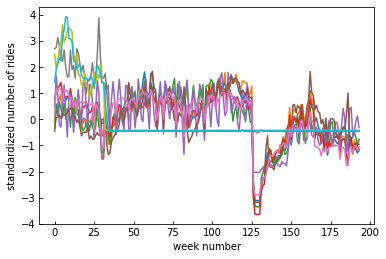

In [25]:
standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [34]:
allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]

[71890.84869151471,
 2091.2375892149093,
 282.7639968279143,
 915.9172085646317,
 407.4856463124503,
 21297.24948453608,
 41997.96748612212,
 29.473909595559086,
 3439.0558287073763,
 1505.7963521015074]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

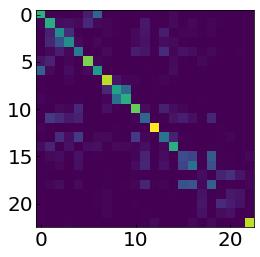

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

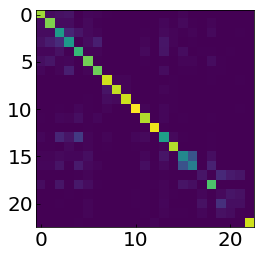

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   